In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Importar dataset

In [ ]:
dataset_path = '../data/dogs'
im_size = (224, 224)
batch_size = 32

im_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255, 
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15
    )

train_generator = im_generator.flow_from_directory(
    dataset_path,
    target_size=im_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=1425
)

val_generator = im_generator.flow_from_directory(
    dataset_path,
    target_size=im_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=1425
)


## Visualizar ejemplos

Found 10222 images belonging to 120 classes.


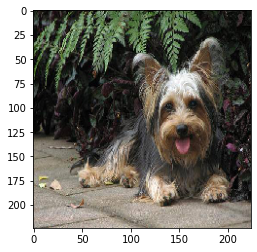

australian_terrier


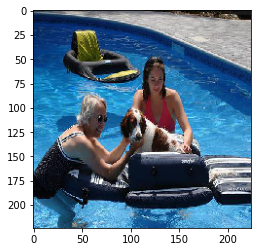

welsh_springer_spaniel


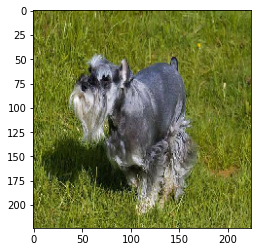

miniature_schnauzer


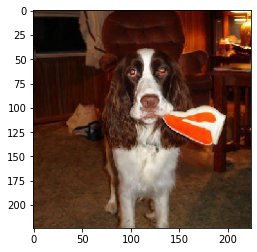

english_springer


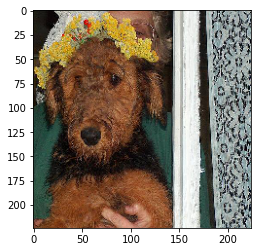

airedale


In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_batches = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255).flow_from_directory(dataset_path, batch_size=10,target_size=im_size)
classes = {value: key for key, value in test_batches.class_indices.items()}
# print(classes)
x_batch, y_batch = next(test_batches)
for i in range (5):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()
    print(classes[np.argmax(y_batch[i])])

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=im_size + (3,), num_classes=120)
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

## Entrenamiento


In [ ]:
epochs = 50
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_generator, epochs=epochs, callbacks=callbacks, validation_data=val_generator,
)